In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

## Markov Chain Monte Carlo methods in Bayesian inference

When encountering more complicated Bayesian models, it is often the case that the calculation of the posterior is difficult, and in practice, we can use only by numerical methods. 

A widely used approach for sampling from the posterior distribution is to use a Markov Chain Monte Carlo method such as the Metropolis-Hastings algorithm:
- It can draw samples from any probability distribution, provided that we know a function $f(x)$ proportional to the PDF of the distribution (and $f(x)$ can be calculated).
- First we define a simmetric proposal density (or jumping distribution) $g(x_{i+1}\mid x_i)$ for proposing the candidate for the next sample based on the current one.
- After starting from a random point, at iteration $t$ we draw a candidate $x'$ for the next point from $g(x\mid x_t)$.
- The acceptance ratio $\alpha$ for the candidate is given by $\alpha=\frac{f(x')}{f(x)}$. Thus, it is accepted with probability 1 if $f(x')>f(x)$ and with probability $f(x')/f(x)$ otherwise. (If the candidate is not accepted, then $x_{t+1}=x_t$.

A Python package for MCMC is given by **pymc**, that we are going to use in a simple Bayesian inference problem.

### Problem definition

Let's study a simple Bayesian linear regression model with normal priors for the parameters! 

We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$
Y\sim {\mathcal N}(\mu,\sigma),
$$

$$
\mu =\alpha+\beta_1\cdot X_1 + \beta_2\cdot X_2,
$$
where $\alpha$ is the intercept, $\beta_1,\beta_2$ are the regression coefficients and $\sigma$ can be viewed as the observational noise.

### Data generation

Let us first generate the observed data according to the above:

In [15]:
alpha, sigma = 2, 1
beta = [0.5, 3.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

<Figure size 640x480 with 0 Axes>

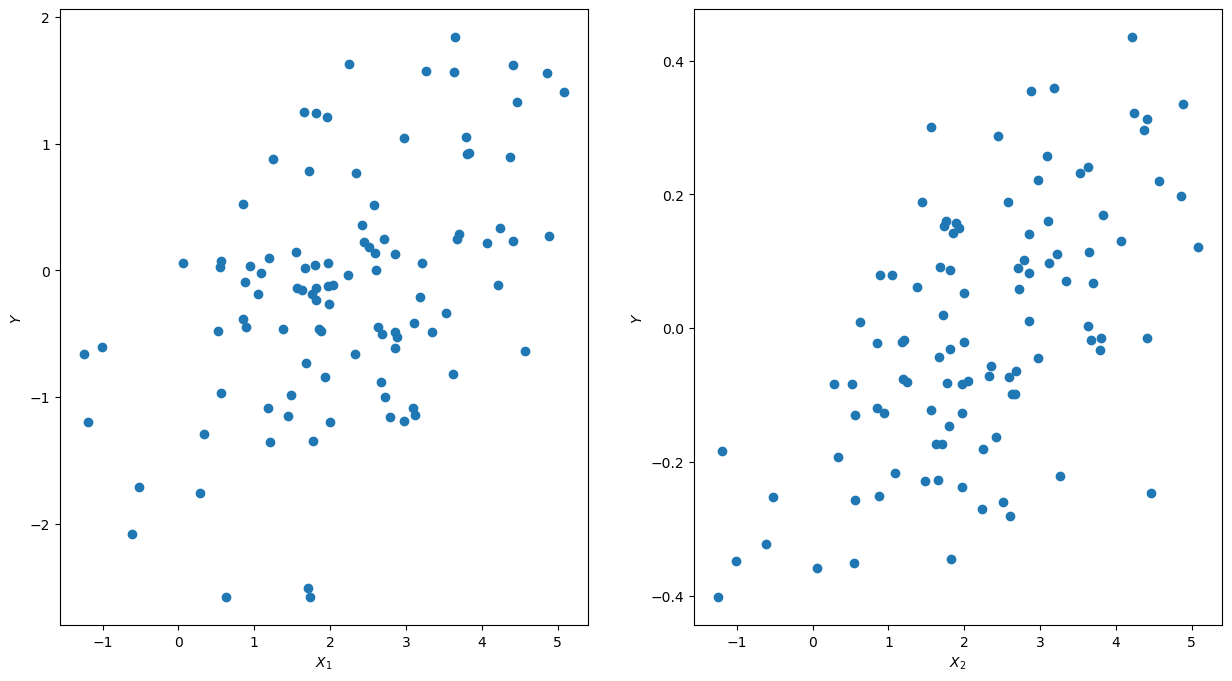

In [16]:
plt.clf();
f, axs = plt.subplots(1,2,figsize=(15,8))
plt.subplot(1,2,1);
plt.scatter(Y,X1);
plt.xlabel(r'$X_1$');
plt.ylabel(r'$Y$');

plt.subplot(1,2,2);
plt.scatter(Y,X2);
plt.xlabel(r'$X_2$');
plt.ylabel(r'$Y$');
plt.show();

<Figure size 640x480 with 0 Axes>

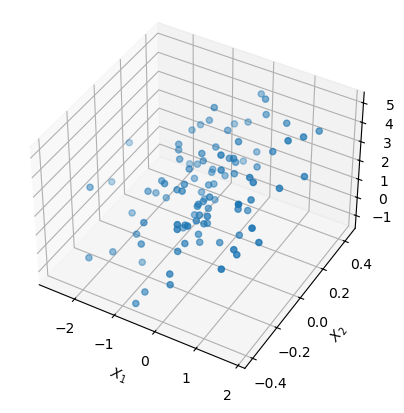

In [17]:
plt.clf();
my_fig = plt.figure();
ax = my_fig.add_subplot(111, projection = '3d');
ax.scatter(X1,X2,Y,'o');
ax.view_init(40,300);
ax.dist = 11; 
plt.xlabel(r'$X_1$');
plt.ylabel(r'$X_2$');
ax.set_zlabel(r'$Y$',rotation = 0);
plt.show();

### Model definition

Since we want to do Bayesian inference, we need to set the prior distributions somehow. Here we choose a normal distribution for the intercept and also for the regression coefficients, and a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.
$$
\alpha \sim {\mathcal N}(0,10), \;\; \beta_1 \sim {\mathcal N}(0,10), \;\; \beta_2 \sim {\mathcal N}(0,10), \;\; \sigma \sim \left|{\mathcal N}(0,1)\right|.
$$

We define the Bayesian model using pymc3:

In [18]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

### Model fitting

Now we can fit the model to the observed data. 

Firt we just provide a "best" estimate for $\alpha,\beta_1,\beta_2$ and $\sigma$, i.e., a point estimation. This is done by looking for the **maximum a posteriori** estimate of the model (MAP).

In [19]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

Output()

{'alpha': array(2.34445681),
 'beta': array([0.67847971, 4.24622686]),
 'sigma_log__': array(-0.11451207),
 'sigma': array(0.89180117)}

Next, let's sample from the posterior distribution with MCMC!

This way, we can have an estimate also for the distribution of the parameters of interest.

In [20]:
with basic_model:
    # draw 1000 posterior samples
    trace = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [13]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
trace.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[0.94009065, 1.00349245, 0.94505576, 1.1779892 , 1.08436709],
       [0.9793335 , 1.18195928, 0.92671474, 1.24121879, 0.94218509],
       [0.9295108 , 1.09929758, 0.91300148, 1.19510432, 1.20391605],
       [1.21720938, 1.27566702, 0.80027596, 1.03195866, 1.04872046]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

The arviz package has a method for instant plotting of such traces, let's try it out!

In [10]:
import arviz as az

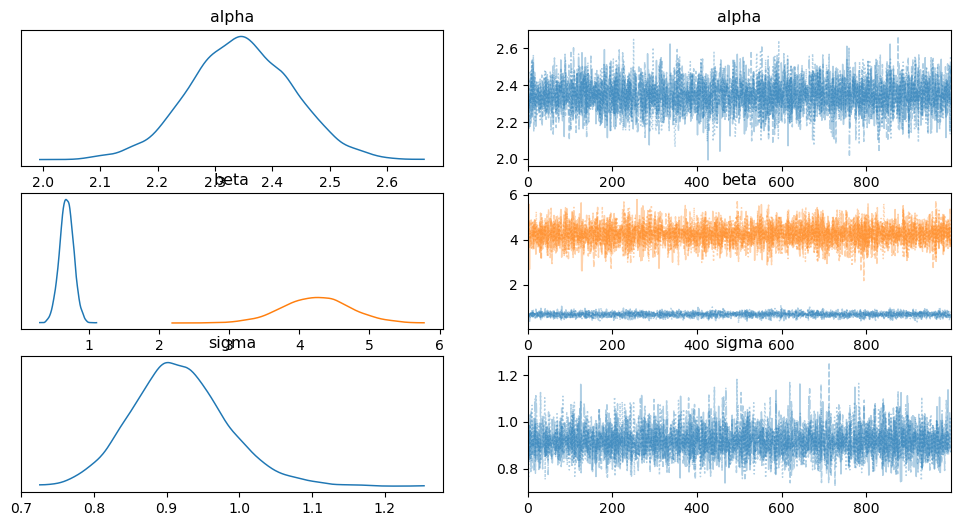

In [21]:
az.plot_trace(trace, combined=True);

For more info on using pymc3 visit https://docs.pymc.io/en/v3/